# **Project Description:Twitter Sentiment Analysis for 'US-Airline'**

Problem statement is to classify sentiment as positive, negative and neutral based on the tweets.

In [ ]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
import seaborn as sns
import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# mount drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the csv file and convert it into pandas dataframe
twitter_df = pd.read_csv("/content/drive/MyDrive/Tweets.csv")

In [ ]:
# Get the information about data and its type
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
twitter_df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
#sns.countplot(x="text", data=twitter_df,hue="airline_sentiment")

In [ ]:
#Print the data shape
twitter_df.shape


(14640, 15)

In [ ]:
twitter_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
twitter_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Only keeping airline_sentiment, text from the data, as these are useful for our analysis and dropping rest of the columns

twitter_df = twitter_df.loc[:14639, ['airline_sentiment', 'text']]
twitter_df.head

<bound method NDFrame.head of       airline_sentiment                                               text
0               neutral                @VirginAmerica What @dhepburn said.
1              positive  @VirginAmerica plus you've added commercials t...
2               neutral  @VirginAmerica I didn't today... Must mean I n...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
...                 ...                                                ...
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14637           neutral  @AmericanAir Please bring American Airlines to...
14638          negative  @AmericanAir you have my money, you change my ...
14639           neutral  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 2 columns]>

In [ ]:
twitter_df.isnull().sum(axis=0)                                # Check for NULL values.

airline_sentiment    0
text                 0
dtype: int64

In [ ]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [ ]:

pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

twitter_df.head()                                 # Check first 5 rows of data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


# **Data Pre-processing:** 
Removal of html tags. Replace contractions in string. (e.g. replace I'm --> I am) and so on.
Remove numbers. Tokenization To remove Stopwords. Lemmatized data, NLTK library is used to tokenize words , remove stopwords and lemmatize the remaining words, convert upper case to lower, removal Html tag removal, Tokenization, Remove the numbers, Special Characters and Punctuations.

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

twitter_df['text'] = twitter_df['text'].apply(lambda x: strip_html(x))
twitter_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

twitter_df['text'] = twitter_df['text'].apply(lambda x: replace_contractions(x))
twitter_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [ ]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

twitter_df['text'] = twitter_df['text'].apply(lambda x: remove_numbers(x))
twitter_df.head()

# Why remove numbers here - based on problem statement as numbers arent useful for Sentiment Analysis

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [ ]:
# Tokenization each word in the text of data
twitter_df['text'] = twitter_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 

In [ ]:
twitter_df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [ ]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))           
# Extra stop words beyond nltk that we want to leverage, Use set operations to reduce stop words -> or add as well.

In [ ]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

twitter_df['text'] = twitter_df.apply(lambda row: normalize(row['text']), axis=1)
twitter_df.head()


,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


In [ ]:
data_features_text = np.array(twitter_df["text"])   
data_features_text

array(['virginamerica dhepburn say',
       'virginamerica plus add commercials experience tacky',
       'virginamerica not today must mean need take another trip', ...,
       'americanair please bring american airlines blackberry',
       'americanair money change flight not answer phone suggestions make commitment',
       'americanair ppl need know many seat next flight plz put us standby people next flight'],
      dtype=object)

In [ ]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [ ]:
labels = twitter_df['airline_sentiment']


In [ ]:
twitter_df.shape

(14640, 2)

In [ ]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features_text, labels, test_size=0.2, random_state=42,stratify=labels)

In [ ]:
y_train.value_counts()

# Data is more skewed towards negative sentiments

negative    7342
neutral     2479
positive    1891
Name: airline_sentiment, dtype: int64

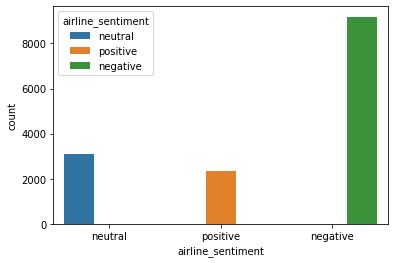

In [ ]:
sns.countplot(x="airline_sentiment", data=twitter_df,hue="airline_sentiment")

In [ ]:
#import imblearn library
#from imblearn.over_sampling import SMOTENC
#oversample = SMOTENC(categorical_features=['neutral', 'positive', 'negative'], random_state = 100)
#X_train= X_train.reshape(-1, 1)
#y_train= y_train.reshape(-1, 1)

#X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
X_train[5]

'americanair pay accommodations ones cancel flightling reason know say lie weather'

In [ ]:
y_train.iloc[5]

'negative'

In [ ]:
y_test.value_counts()

negative    1836
neutral      620
positive     472
Name: airline_sentiment, dtype: int64

In [ ]:

print(X_train.shape)
print(y_train.shape)

(11712,)
(11712,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(2928,)
(2928,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
X_train_vec = vectorizer.fit_transform(X_train)



In [ ]:
vectorizer.get_feature_names()[:20]

['aa',
 'able',
 'absolute',
 'absolutely',
 'accept',
 'acceptable',
 'access',
 'accommodate',
 'account',
 'act',
 'actual',
 'actually',
 'add',
 'address',
 'advisory',
 'afternoon',
 'agent',
 'agents',
 'ago',
 'ahead']

In [ ]:

# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train_vec, y_train)

print(forest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
print(np.mean(cross_val_score(forest, X_train_vec, y_train, cv=10)))

0.7443640102243348


In [ ]:
# Predict the result for test data using the model built above.
X_test_vec = vectorizer.fit_transform(X_test)
result = forest.predict(X_test_vec)
result


array(['negative', 'positive', 'negative', ..., 'neutral', 'positive',
       'positive'], dtype=object)

In [ ]:
print('Accuracy on Test Data Set',sum(result == y_test) / len(y_test))

Accuracy on Test Data Set 0.4822404371584699


[[996 684 156]
 [296 284  40]
 [195 145 132]]


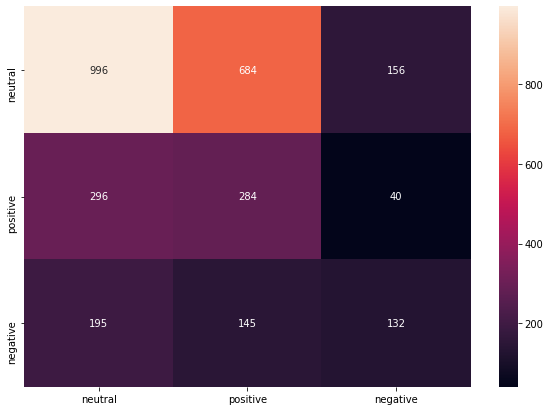

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ('neutral','positive','negative')],
                  columns = [i for i in ('neutral','positive','negative')])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:

# Using LogisticRegression to build model for the classification of reviews.
# Also calculating the cross validation score.


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(random_state=7,max_iter=1000)

logreg = logreg.fit(X_train_vec, y_train)

print(logreg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
print(np.mean(cross_val_score(logreg, X_train_vec, y_train, cv=10)))

0.7857735869403648


In [ ]:
# Predict the result for test data using the model built above.
X_test_vec = vectorizer.fit_transform(X_test)
result = logreg.predict(X_test_vec)
result


array(['negative', 'positive', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [ ]:
print('Accuracy on Test Data Set',sum(result == y_test) / len(y_test))

Accuracy on Test Data Set 0.5556693989071039


[[1369  173  294]
 [ 423  105   92]
 [ 276   43  153]]


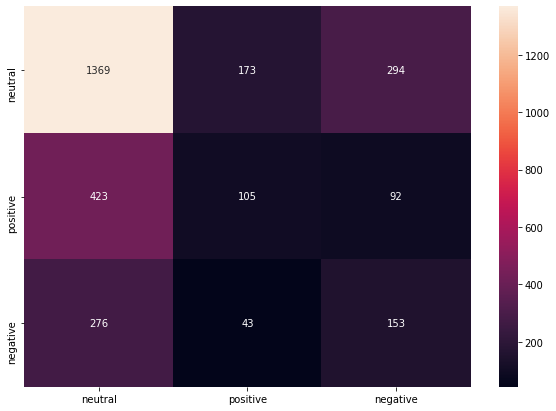

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ('neutral','positive','negative')],
                  columns = [i for i in ('neutral','positive','negative')])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)

In [ ]:

# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train_tfidf, y_train)

print(forest)
RndmFrst_tfidf = np.mean(cross_val_score(forest, X_train_tfidf, y_train, cv=10))

print("Randomforest with tfidf Accuracywith train data: ", RndmFrst_tfidf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Randomforest with tfidf Accuracywith train data:  0.7468395059209625


In [ ]:
X_test_tfidf = vectorizer_tfidf.fit_transform(X_test)
result = forest.predict(X_test_tfidf)

In [ ]:
print('Accuracy on Test Data Set',sum(result == y_test) / len(y_test))

Accuracy on Test Data Set 0.5365437158469946


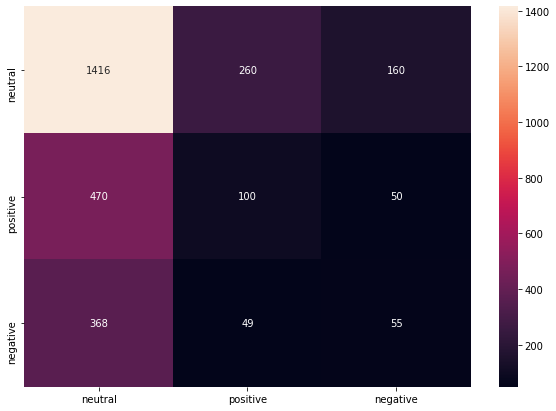

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ('neutral','positive','negative')],
                  columns = [i for i in ('neutral','positive','negative')])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
# Model performs best at 5s and worst at 0s - error analysis to see why negative sentiment words arent being picked up

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

logreg = LogisticRegression(random_state=7,max_iter=1000)

logreg = logreg.fit(X_train_tfidf, y_train)

print(logreg)

print("LogisticReg Accuracy on Train data:",(np.mean(cross_val_score(logreg, X_train_tfidf, y_train, cv=10))))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticReg Accuracy on Train data: 0.782445650431503


In [ ]:
X_test_tfidf = vectorizer_tfidf.fit_transform(X_test)
result = logreg.predict(X_test_tfidf)

In [ ]:
print('Accuracy on Test Data Set',sum(result == y_test) / len(y_test))

Accuracy on Test Data Set 0.5782103825136612


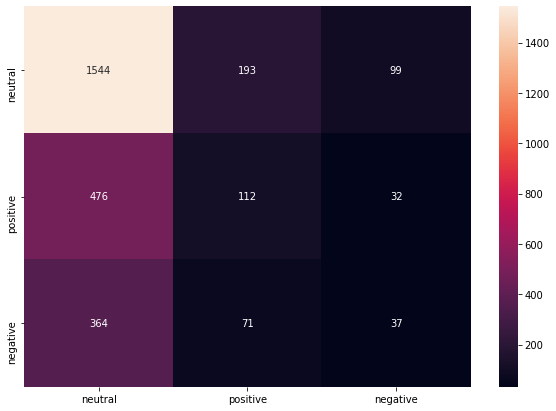

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ('neutral','positive','negative')],
                  columns = [i for i in ('neutral','positive','negative')])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Deep Neural Network with Word Embeddings layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

length = 0
for i in range(0,len(X_train)):
  length = length + len(X_train[i])
print('Avg Length of Sequences',length/X_train.shape[0])

Avg Length of Sequences 66.76886953551913


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = 50000,oov_token=oov_tok)  # Keras Tokenizer
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
X_train_tokenize = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(X_train_tokenize,maxlen=max_length,truncating=trunc_type, padding='post')

X_test_tokenize = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(X_test_tokenize,maxlen=max_length,truncating=trunc_type, padding='post')

In [ ]:
#Vocab size
len(tokenizer.word_index) + 1

10509

In [ ]:
#Padded sequence used as input to Keras Model
print(X_train[2])
print(X_train_tokenize[2])
print(padded[2])

unite flight cancel flightlations one due weather one mechanical pay hotel bag hold transfer vouchercompensation
[3, 2, 12, 510, 33, 100, 71, 33, 356, 91, 160, 19, 25, 585, 4277]
[   3    2   12  510   33  100   71   33  356   91  160   19   25  585
 4277    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
for word in ['good', 'nice', 'happy', 'sad', 'ok','super']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

good: 82
nice: 197
happy: 287
sad: 626
ok: 246
super: 544


In [ ]:
# Convert  multi-class labels to binary labels using LabelBinarizer
# LabelBinarizer makes this process easy with the transform method.

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [ ]:
print(y_train.shape)
print(y_test.shape)

(11712, 3)
(2928, 3)


In [ ]:
y_train[2]

array([1, 0, 0], dtype=int64)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
#y = [[0], [1], [2], [3]]
y = [0, 1, -1]
#keras.utils.to_categorical(y)
#ohe = OneHotEncoder()
#ohe.fit_transform(y).toarray()
pd.get_dummies(y)

,-1,0,1
0,0,1,0
1,0,0,1
2,1,0,0


In [ ]:
#First Model - Word Embedding Vector with Dense Layers
import tensorflow as tf

model = tf.keras.Sequential()
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
                             tf.keras.layers.GlobalMaxPool1D(),
                             tf.keras.layers.Dense(16,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           168144    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 168,467
Trainable params: 168,467
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
366/366 [==============================] - 2s 4ms/step - loss: 0.9377 - accuracy: 0.6025 - val_loss: 0.6483 - val_accuracy: 0.7367
Epoch 2/30
366/366 [==============================] - 1s 3ms/step - loss: 0.5933 - accuracy: 0.7672 - val_loss: 0.5555 - val_accuracy: 0.7824
Epoch 3/30
366/366 [==============================] - 1s 3ms/step - loss: 0.4690 - accuracy: 0.8240 - val_loss: 0.5241 - val_accuracy: 0.7883
Epoch 4/30
366/366 [==============================] - 1s 3ms/step - loss: 0.3612 - accuracy: 0.8685 - val_loss: 0.5170 - val_accuracy: 0.7958
Epoch 5/30
366/366 [==============================] - 1s 3ms/step - loss: 0.2957 - accuracy: 0.8961 - val_loss: 0.5308 - val_accuracy: 0.7971
Epoch 6/30
366/366 [==============================] - 1s 3ms/step - loss: 0.2336 - accuracy: 0.9221 - val_loss: 0.5568 - val_accuracy: 0.7951
Epoch 7/30
366/366 [==============================] - 1s 3ms/step - loss: 0.1904 - accuracy: 0.9381 - val_loss: 0.5906 - val_accuracy: 0.7896
Epoch 

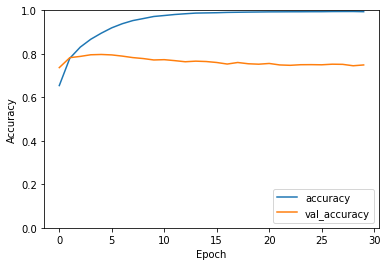

In [ ]:
num_epochs = 30
history = model.fit(padded,y_train,epochs = num_epochs, validation_data=(testing_padded,y_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

In [ ]:
# Each word in Vocab with embedding vector
e =model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #shape:(vocab_size,embedding_dim)

(10509, 16)


In [ ]:
#Vector of 16 for each word
weights[0]

array([-0.229036  , -0.2178464 , -0.23151651, -0.26220495, -0.41428173,
       -0.25695625, -0.25225922, -0.31643337, -0.3269577 , -0.30512244,
       -0.3063345 , -0.369803  , -0.23793647, -0.33177096, -0.28968564,
       -0.3096736 ], dtype=float32)

In [ ]:

## Model using Pretrained Embedding Weights - Glove Method

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
# Extract the files from dataset, as the dataset is as zip file.

# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/glove.6B.300d.txt.zip', 'r') as zip:
  zip.extractall('/content/drive/MyDrive/Colab_Notebooks/glove')
  zip.close()

In [ ]:
from keras.preprocessing.text import Tokenizer
filepath = "/content/drive/MyDrive/Colab_Notebooks/glove/glove.6B.300d.txt"
embedding_matrix = create_embedding_matrix(filepath,tokenizer.word_index, embedding_dim)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           168144    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 39        
Total params: 168,387
Trainable params: 168,387
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
366/366 [==============================] - 2s 4ms/step - loss: 0.9554 - accuracy: 0.5629 - val_loss: 0.8446 - val_accuracy: 0.6342
Epoch 2/30
366/366 [==============================] - 1s 3ms/step - loss: 0.8018 - accuracy: 0.6547 - va

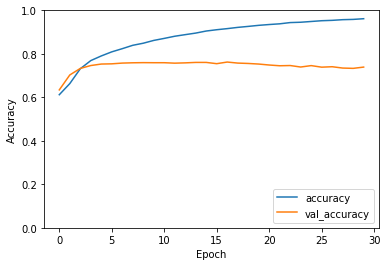

In [ ]:

#Model 2 - Keras model with pretrained embedding vectors
#The glove file can be obtained at https://github.com/stanfordnlp/GloVe
embedding_dim = 16
model_glove = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length = max_length),
                             tf.keras.layers.GlobalMaxPool1D(),
                             tf.keras.layers.Dense(12,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model_glove.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_glove.summary()

num_epochs = 30
history_glove = model_glove.fit(padded,y_train,epochs = num_epochs,validation_data=(testing_padded,y_test))

plt.plot(history_glove.history['accuracy'], label='accuracy')
plt.plot(history_glove.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

In [ ]:
#Lof of word vectors in current Vocab not in Glove Pretrained vector list
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

0.627081549148349


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           168144    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
366/366 [==============================] - 11s 25ms/step - loss: 0.9729 - accuracy: 0.6324 - val_loss: 0.9157 - val_accuracy: 0.6270
Epoch 2/40
366/366 [==============================] - 9s 25ms/step - loss: 0.9233 - accuracy: 0.6213 -

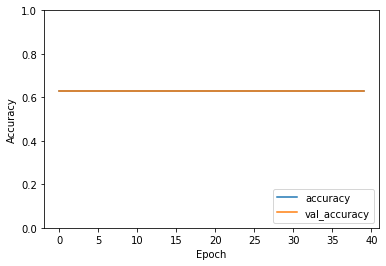

In [ ]:
#Model using LSTM - No performance model using LSTM and other similar models
model_lstm = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
                             tf.keras.layers.LSTM(16),
                             tf.keras.layers.Dense(12,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

num_epochs = 40
history_lstm = model_lstm.fit(padded,y_train,epochs = num_epochs,validation_data=(testing_padded,y_test))

plt.plot(history_lstm.history['accuracy'], label='accuracy')
plt.plot(history_lstm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           168144    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 39        
Total params: 181,507
Trainable params: 181,507
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
366/366 [==============================] - 10s 26ms/step - loss: 0.9163 - accuracy: 0.6269 - val_loss: 0.9160 - val_accuracy: 0.6270
Epoch 2/40
366/366 [==============================] - 10s 26ms/step - loss: 0.9162 - accuracy: 0.6269 

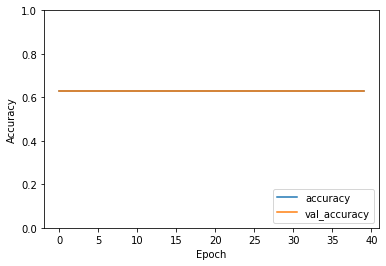

In [ ]:

#Model using Bidirectional LSTM 
model_bilstm = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(12,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model_bilstm.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])
model_bilstm.summary()
num_epochs = 40
history_bilstm = model_lstm.fit(padded,y_train,epochs = num_epochs,validation_data=(testing_padded,y_test))

plt.plot(history_bilstm.history['accuracy'], label='accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 16)           168192    
_________________________________________________________________
conv1d (Conv1D)              (None, 295, 20)           1940      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2368      
_________________________________________________________________
dense_14 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 39        
Total params: 172,743
Trainable params: 172,743
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
366/366 [==============================] - 34s 87ms/step - loss: 0.9717 - accuracy: 0.6064 - val_loss: 

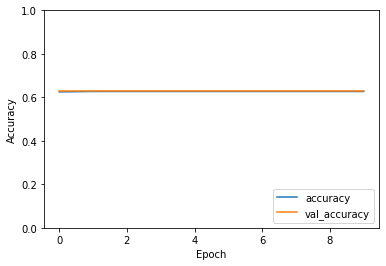

In [ ]:
#Model using Conv1D & LSTM
model_conv1d_lstm = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
                             tf.keras.layers.Conv1D(20, 6, activation='relu'), # 20 filters
                             tf.keras.layers.LSTM(16),
                             tf.keras.layers.Dense(12,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model_conv1d_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_conv1d_lstm.summary()

num_epochs = 25
history_conv1d_lstm = model_conv1d_lstm.fit(padded,y_train,epochs = num_epochs,validation_data=(testing_padded,y_test))

plt.plot(history_conv1d_lstm.history['accuracy'], label='accuracy')
plt.plot(history_conv1d_lstm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 16)           168192    
_________________________________________________________________
lstm_7 (LSTM)                (None, 300, 32)           6272      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_18 (Dense)             (None, 12)                204       
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 39        
Total params: 177,843
Trainable params: 177,843
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
366/366 [==============================] - 64s 168ms/step - loss: 0.9545 - accuracy: 0.6171 - val_loss

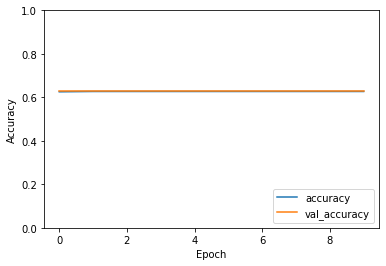

In [ ]:

#Model using Deep LSTM - 2 LSTM layers
model_deeplstm = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
                             tf.keras.layers.LSTM(32,return_sequences=True),
                             tf.keras.layers.LSTM(16),
                             tf.keras.layers.Dense(12,activation='relu'),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model_deeplstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_deeplstm.summary()

num_epochs = 20
history_deeplstm = model_deeplstm.fit(padded,y_train,epochs = num_epochs,validation_data=(testing_padded,y_test))

plt.plot(history_deeplstm.history['accuracy'], label='accuracy')
plt.plot(history_deeplstm.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

# **Conclusions:**

Problem statement is to analyse U.S. airline Twitter data and predict the sentiment of given text based on the ML models.

Given raw data can not be processed as such it requires preprocessing to reduce the noise and minimize the total number of words which are having high importance in predicition by removing unwanted words in the test. Basically data preprocessing is a data mining technique which is used to transform the raw data in a useful and efficient format.

Data Pre-processing:
Removal of html tags. Replace contractions in string. (e.g. replace I'm --> I am) and so on. Remove numbers. Tokenization To remove Stopwords. Lemmatized data, NLTK library is used to tokenize words , remove stopwords and lemmatize the remaining words, convert upper case to lower, removal Html tag removal, Tokenization, Remove the numbers, Special Characters and Punctuations.

All numeric and punctuation has been replaced with space
Removing all irrelevant characters (Numbers and Punctuation)
Removing URL
Convert all characters into lowercase
Removing Stopwords —
“Stopwords” are the most common words in a language like “the”, “a”, “me”, “is”, “to”, “all”,. These words do not carry important meaning and are removed from text using Natural Language Toolkit (nltk). 

Stemming and Lemmatization —
The aim of both processes is the same: reducing the inflectional forms of each word into a common base or root. Both process are different where Stemming refers to a crude process that chops off the ends of word in the hope of achieving this goal correctly most of the time.
On the other hand, lemmatization consists in doing things properly with the use of a vocabulary and morphological analysis of words, to return the base or dictionary form of a word, which is known as the lemma. So lemmatization is been used


Tokenization —
Tokenization is the process of splitting the given text into smaller pieces called tokens. Words, numbers, punctuation marks, and others can be considered as tokens. So used Natural language tool kit (nltk) library for tokenization as a result string has been changed into tokens, that has been stored in the form of ‘list of string’ 


In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words so it ends up in ignoring the rare words. To overcome this, we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents. IDF tells us if a word (feature) can be used to distinguish documents. If a word appears in  majority of the documents  then IDF will be close to ‘0’ i.e. give low weightage to that feature.

Random Forest and logistic regression ML models are built with count vectorizer and TF-IDF Vectoriser for the above sentiment classification problem where accuracy score was 
74% and 78% respectively for training data but for test data accuracy score was around 55 to 58%. So we can say that traing data is overfit and badly performed with test data. This may be due to uneven distribution of the data.

Sequential Model - Word Embedding Vector with Dense Layers
embedding_dim = 16 is built with Adam optimizer and classification entrophy as loss function with learning rate of .001.and relu activation funtion is used. DNN is built max pooling before the output layer where softmax function as it is a classification problem.Accuracy is used as a metrics and model produced 98% accuracy in training and 73% accuracy in testing.

**Sequential Model - pretrained glove embedding vectors with Dense Layers and embedding_dim = 16** is built with Adam optimizer and categorical cross entrophy as loss function, relu activation funtion is used. DNN is built global max pooling before the output layer where softmax function as it is a classification problem. Accuracy is used as a metrics and model produced **96% accuracy in training and 73% **accuracy in testing with pretrained embedding vectors

**Sequential Model using LSTM **is built with unidirectional and bidirectional weights where observed that training and test accuracy score is converged but it around **65% **even after changing different learning rates and activation function and tried with ADAgrad optimizer as well.

so dense neural networks with sequential model with embedding dimension, Adam optimizer  and categorical cross entrophy as loss function, relu activation funtion is used. DNN is built global max pooling before the output layer where softmax function as it is a classification problem. Accuracy is used as a metrics and model produced **96% accuracy in training and 74% ** is the best score amongst all the other models.
